# Introduction

Author: Joaquim Minarelli Gaspar

Date: 7/3/2023

This code is part of the research project entitled "Hamiltonian representation of a
neutral atom quantum computer
using the ZW-Calculus graphical
language", carried out from 06/15/2023 to 08/18/2023 at Inria, with the QuaCS-LMF group.

# Instaling library

In [1]:
# Instaling library
using Bloqade

# Optimization library
using CPLEX, JuMP

using Plots
using LinearAlgebra

# Initializing the parameters

In [16]:
# Identity
I = [1 0;
    0 1];

# Z
Z = [1 0;
    0 -1];

# Y
Y = [0 -1im;
    1im 0];

# X
X = [0 1;
    1 0];

# Defining the number operator
n11 = [0 0;
       0 1];

# C6 constant 
C6 = 2*π*862690;

# Convergence variable
epsilon = 10^(-1);

# Defining the Hamiltoninan that represents a quantum algorithm
H = [0 35.9356 35.9356 0;
    35.9356 0 0 35.9356;
    35.9356 0 0 35.9356 ;
    0 35.9356 35.9356 4.75869e5];

# Number of qubits
n = convert(Int, log2(size(H,1)));

# Creating the permutation matrix for the case n > 1 (used to define the Hamiltonian equation)
if n >= 2
    pair = Matrix{Int}(undef, n*(n-1)÷2, 2)
    k = 1
    for i in 1:n-1
        for j in i+1:n
            pair[k, 1] = i
            pair[k, 2] = j
            k += 1
        end
    end
end

# Optimization function

In [17]:
function cplexSolve(H)
    # Create the model
    m = JuMP.Model(CPLEX.Optimizer)

    # Model variables

    # Rabi frequency
    # @variable(m, Omega)
    @variable(m, Omega[1:n])

    # Detuning frequency
    # @variable(m, delta)
    @variable(m, delta[1:n])

    # Distance between atoms
    @variable(m, R[1:n, 1:n])

    # Model constraints

    @constraint(m, [i in 1:n] , Omega[i] >= 0)

    @constraint(m, [i in 1:n, j in 1:n], R[i, j] == R[j, i])

    @constraint(m, [i in 1:n], R[i, i] == 0)

    @constraint(m, [i in 1:n, j in 1:n], R[i, j] >= 0)

    # Constructing the Rydberg Hamiltonian Matrix
    # It's divided into 3 parts: Pauli X - Number operator - Coupling terms

    # Part 1 - Pauli X
    # It has n components inside the sum
    pauliXList = []; # it will have n pauliX matrices
    for atom in 1:n
        A = X; # A will be just an auxiliary matrix
        if atom != 1
            for i = 1:(atom - 1)
                A = kron(I, A);
            end
        end
        if atom != n
            for i = (atom + 1):n
                A = kron(A, I);
            end
        end
        A = (Omega[atom]/2)*A;
        push!(pauliXList, A)
    end

    # Part 2 - Number operator
    # It has n components inside the sum
    numberOperatorList = [];
    for atom in 1:n
        A = n11; # A will be just an auxiliary matrix
        if atom != 1
            for i = 1:(atom - 1)
                A = kron(I, A);
            end
        end
        if atom != n
            for i = (atom + 1):n
                A = kron(A, I);
            end
        end
        A = (-(delta[atom]))*A;
        push!(numberOperatorList, A)
    end

    # Part 3 - Coupling terms
    # It has (n*(n-1))/2 components inside the sum
    couplingTermsList = [];

    if n == 1
        A = [0 0;0 0]; # auxiliary matrix
        push!(couplingTermsList, A);
    end

    if n != 1
        current_pair = 1; 
        for coupled_pair in 1:((n*(n-1))/2)
            # Defining the atoms of the current pair (it will be also used later to refer to the atom distances)
            atom1 = pair[current_pair, 1];
            atom2 = pair[current_pair, 2];

            # Defining the position vector
            # this vector will have the value -1 at the positions where we need to put an identity matrix
            # and the value os the atom at the atom position
            # Example: if we have the iteraction between atoms 2 and 4, and we have 5 atoms at total, the vector will be:
            # position = [-1 2 -1 4 -1]

            position_array = Array{Any}(undef, n);
            for i in 1:n   
                if atom1 == i
                    position_array[i] = atom1;
                end
                if atom2 == i
                    position_array[i] = atom2;
                end
                if i != atom1 && i != atom2
                    position_array[i] = -1;
                end
            end

            if atom1 == 1
                A = n11;
            end
            if atom1 != 1
                A = I;
            end

            for i in 1:(n-1)
                if position_array[i+1] == -1
                    A = kron(A, I);
                end
                if position_array[i+1] != -1
                    A = kron(A, n11);
                end
            end

            A = C6*(R[atom1,atom2])*A;
            push!(couplingTermsList, A)
            current_pair += 1;
        end
    end

    # Constructing the Rydberg Hamiltonian Matrix
    Ryd_H = sum(pauliXList) + sum(numberOperatorList) + sum(couplingTermsList);

    # Convergence constraints 
    @constraint(m, [i in 1:(size(H,1)), j in 1:(size(H,1))], H[i,j] - Ryd_H[i,j] <= epsilon)
    @constraint(m, [i in 1:(size(H,1)), j in 1:(size(H,1))], H[i,j] - Ryd_H[i,j] >= -epsilon)


    # Objective function == minimize the distance between the 2 hamiltonians
    @objective(m, Min, 1)

    optimize!(m)

    return Omega, delta, R, Ryd_H;
end

cplexSolve (generic function with 1 method)

# Optimization problem solving

In [18]:
Omega, delta, R, Ryd_H = cplexSolve(H);

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
Tried aggregator 1 time.
LP Presolve eliminated 44 rows and 8 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.01 ticks)


# Plotting results

In [19]:
print("\n")
println("Results after system convergence: \n")

for i in 1:n
    println("The Rabi frequency of the atom ", i, " should be: ", round(value(Omega[1])/(2*pi), digits = 3),"*2π");
end

for i in 1:n
    println("The detuning frequency of the atom ", i, " should be: ", round(value(delta[1])/(2*pi), digits = 3),"*2π");
end
print("\n")

current_atom = 1;
for coupled_pair in 1:((n*(n-1))/2)
    atom1 = pair[current_atom, 1];
    atom2 = pair[current_atom, 2];
    println("The distance between the atoms ",atom1," and ",atom2, " should be: ", round(value(R[atom1,atom2])^(-1/6), digits = 3), " µm");
    current_atom += 1;
end

print("\n")

# Rydberg blockade radius
Rb = (C6/(sqrt(value(Omega[1])^2 + value(delta[1])^2)))^(1/6);
println("The Rydberg blockade radius is: ", round(Rb, digits = 3), " µm")


Results after system convergence: 

The Rabi frequency of the atom 1 should be: 11.407*2π
The Rabi frequency of the atom 2 should be: 11.407*2π
The detuning frequency of the atom 1 should be: 0.016*2π
The detuning frequency of the atom 2 should be: 0.016*2π

The distance between the atoms 1 and 2 should be: 1.5 µm

The Rydberg blockade radius is: 6.503 µm


# Hamiltonian simulation using BloQade


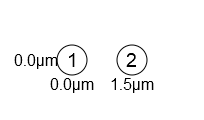

In [20]:
# Global variables
C6 = 2*π*862690;
r = 1.5; # distance between 2 neighbors
epsilon = 5;
Rb = r + epsilon; # Rydberg blockade distance
Ω = C6/(Rb)^6; # Rabi frequency
Δ = 0; # Detuning frequency

# Creating the atoms geometry
atoms = generate_sites(ChainLattice(), 2, scale=r)

In [21]:
# Declaring the hamiltonian
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)

nqubits: 2
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] 2π ⋅ 5.72 ⋅ ∑ σ^x_i
└─ [-] 2π ⋅ 0.0 ⋅ ∑ n_i


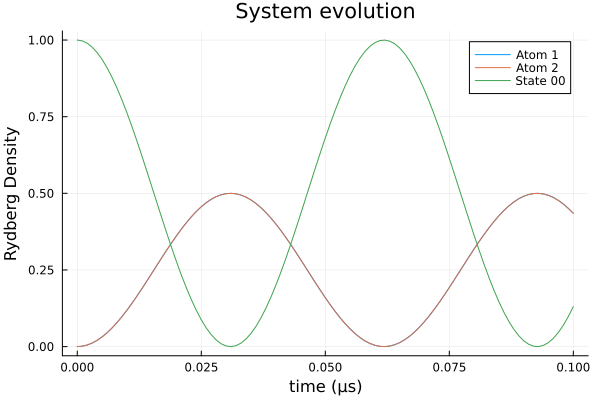

In [22]:
# Total simulation time
T = 0.1;

# Simulation step
step = 0.001;
time_vector = 0.0:step:T;

# Probability matrix
prob_atom1 = Any[];
prob_atom2 = Any[];
prob_00 = Any[];

for i in time_vector
    reg = zero_state(2);
    prob = SchrodingerProblem(reg, i , hamiltonian)
    emulate!(prob)
    push!(prob_atom1, rydberg_density(reg, 1));
    push!(prob_atom2, rydberg_density(reg, 2));
    push!(prob_00, 1 - rydberg_density(reg, 1) - rydberg_density(reg, 2));
end

plot(time_vector, prob_atom1, label = "Atom 1")
plot!(time_vector, prob_atom2, label = "Atom 2")
plot!(time_vector, prob_00, label = "State 00")
title!("System evolution")
xlabel!("time (µs)")
ylabel!("Rydberg Density")